## 1.EDA

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

Mental health is a critical aspect of overall well-being, and understanding the nuances of mental health conditions can be a powerful tool in providing timely support and interventions. In this project, we perform sentiment analysis on textual data to predict the mental health status of individuals based on their statements. By analyzing the language used in these statements, we aim to accurately classify them into one of seven mental health categories: Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, and Personality Disorder.

By applying advanced natural language processing (NLP) techniques and machine learning models, we seek to classify these statements accurately. The insights from this analysis could help mental health professionals in early identification and intervention.


Data Source:
The dataset integrates information from the following Kaggle datasets:

* 3k Conversations Dataset for Chatbot
* Depression Reddit Cleaned
* Human Stress Prediction
* Predicting Anxiety in Mental Health Data
* Mental Health Dataset Bipolar
* Reddit Mental Health Data
* Students Anxiety and Depression Dataset
* Suicidal Mental Health Dataset
* Suicidal Tweet Detection Dataset

All this datasets are combined into one single dataset which is the Below Dataset From Kaggle:
</br>
<a href = "https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health"> 
Sentiment Analysis for Mental Health</a>

### let's Importing All the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Let's Look at the dataset that what dataset has been provided

## 1. Loading the dataset


In [7]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)

In [ ]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Records: {df.duplicated().sum()}")

DATASET OVERVIEW

Dataset Shape: (53043, 2)
Total Records: 53043
Total Features: 2

Column Names: ['statement', 'status']

Data Types:
statement    object
status       object
dtype: object

Missing Values:
statement    362
status         0
dtype: int64

Duplicate Records: 1944


## 2. Target Variable Distribution

**What we're doing:** Analyzing the distribution of mental health statuses in our dataset to understand class balance and sample size for each category.

**Expected Output:** Bar and pie charts showing count and percentage of each status category.


TARGET VARIABLE DISTRIBUTION:
Total samples: 53043

Distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

Percentages:
status
Normal                  30.83
Depression              29.04
Suicidal                20.08
Anxiety                  7.33
Bipolar                  5.42
Stress                   5.03
Personality disorder     2.26
Name: count, dtype: float64%


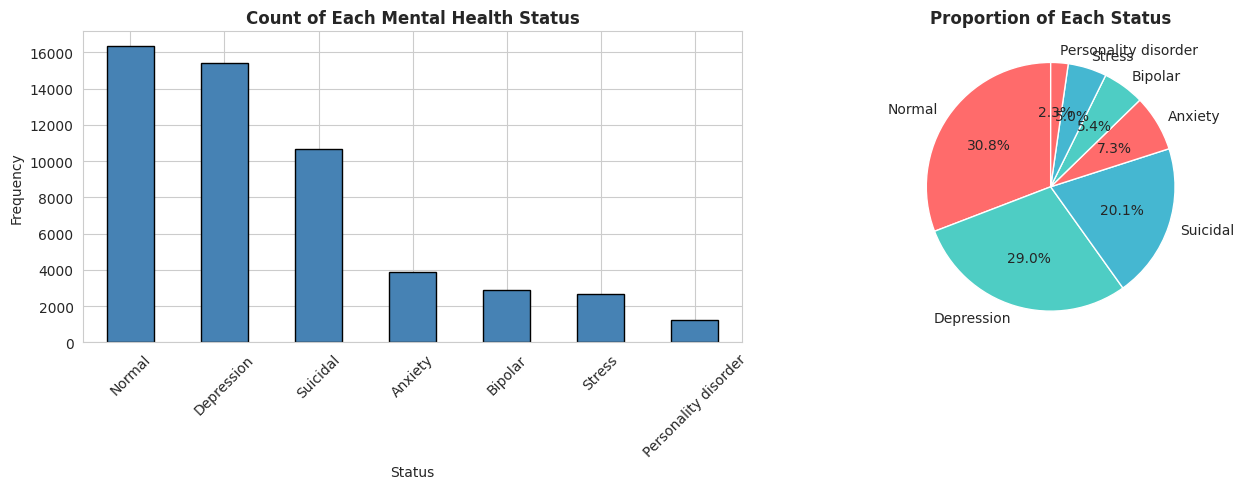


✓ Class Distribution: Imbalanced


In [ ]:
status_counts = df['status'].value_counts()
print("\nTARGET VARIABLE DISTRIBUTION:")
print(f"Total samples: {len(df)}")
print(f"\nDistribution:\n{status_counts}")
print(f"\nPercentages:\n{(status_counts / len(df) * 100).round(2)}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

status_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Count of Each Mental Health Status', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Proportion of Each Status', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

class_balance = 'Balanced' if status_counts.std() < status_counts.mean() * 0.5 else 'Imbalanced'
print(f"\n✓ Class Distribution: {class_balance}")

## 3. Text Data Analysis

**What we're doing:** Examining text characteristics like length and word count to understand data structure and preprocessing needs.

**Expected Output:** Histograms showing distributions and box plots comparing metrics by status.

**Observations:** Reveals text variability and if different health statuses have different text patterns.


TEXT DATA STATISTICS:

Character Count: Min=2, Max=32759, Mean=579
Word Count: Min=1, Max=6300, Mean=113.2


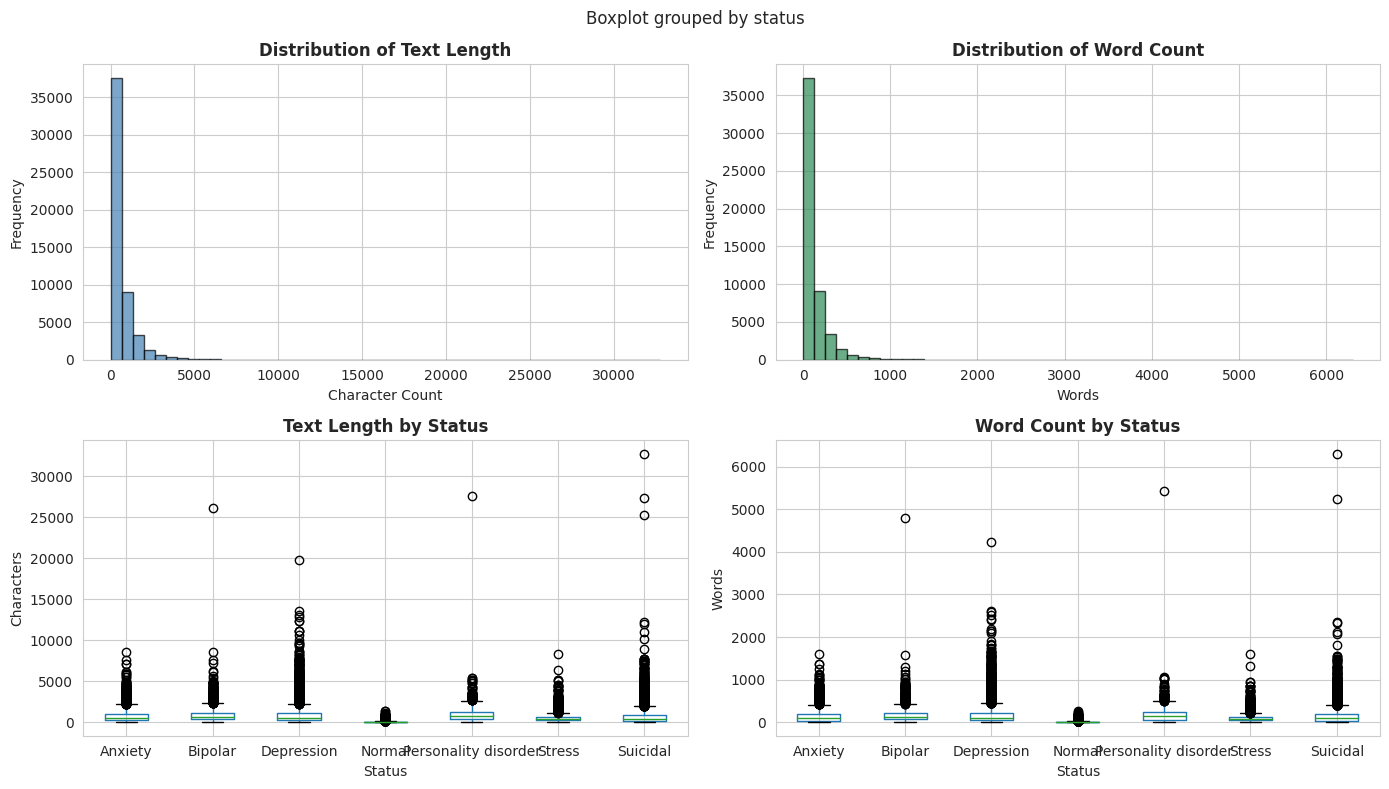


✓ Observation: Text shows good variability suitable for NLP analysis


In [ ]:
df = df.dropna(subset=['statement'])

df['text_length'] = df['statement'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df['word_count'] = df['statement'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

print("\nTEXT DATA STATISTICS:")
print(f"\nCharacter Count: Min={df['text_length'].min()}, Max={df['text_length'].max()}, Mean={df['text_length'].mean():.0f}")
print(f"Word Count: Min={df['word_count'].min()}, Max={df['word_count'].max()}, Mean={df['word_count'].mean():.1f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].hist(df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Text Length', fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['word_count'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Word Count', fontweight='bold')
axes[0, 1].set_xlabel('Words')
axes[0, 1].set_ylabel('Frequency')

df.boxplot(column='text_length', by='status', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Status', fontweight='bold')
axes[1, 0].set_xlabel('Status')
axes[1, 0].set_ylabel('Characters')

df.boxplot(column='word_count', by='status', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Status', fontweight='bold')
axes[1, 1].set_xlabel('Status')
axes[1, 1].set_ylabel('Words')

plt.tight_layout()
plt.show()

print("\n✓ Observation: Text shows good variability suitable for NLP analysis")

## 4. Word Cloud Visualization

**What we're doing:** Creating visual word clouds to show the most frequently occurring words in mental health statements. Word size represents frequency.

**Expected Output:** Visual word clouds showing dominant themes by status category.

**Observations:** Common themes reveal what words/concerns dominate each mental health category.


Generating word clouds for 7 mental health categories...


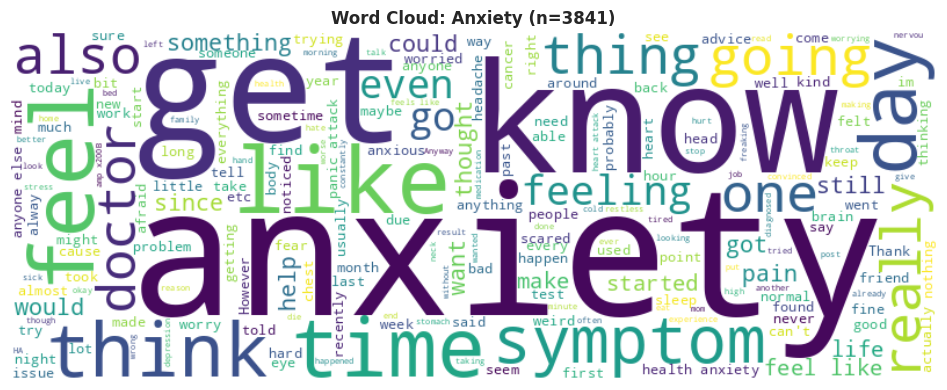

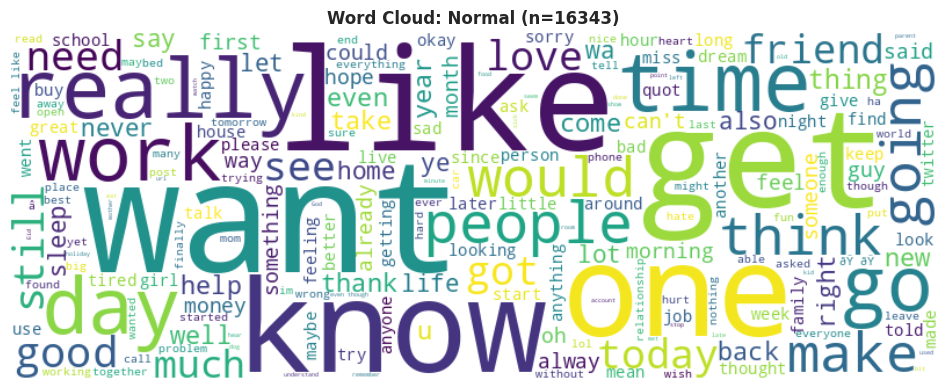

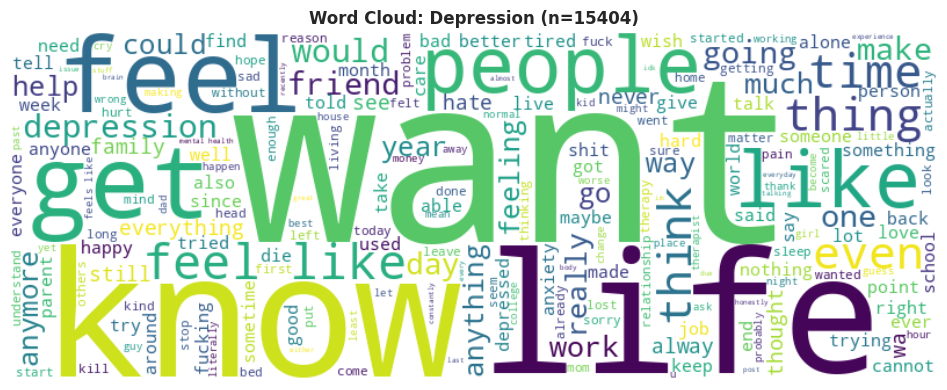

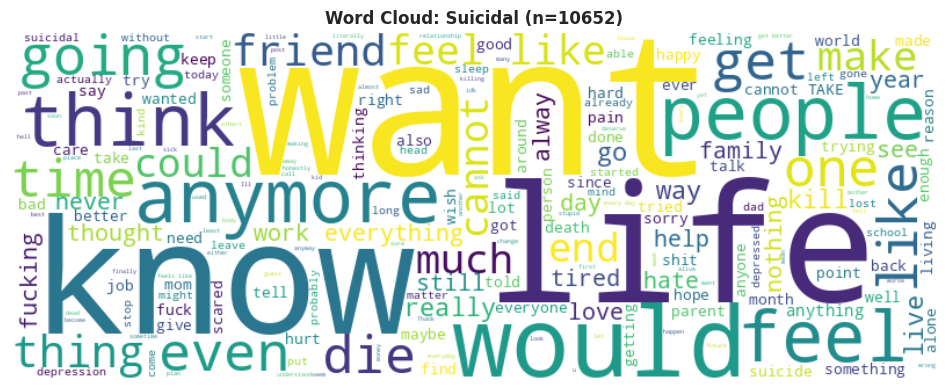

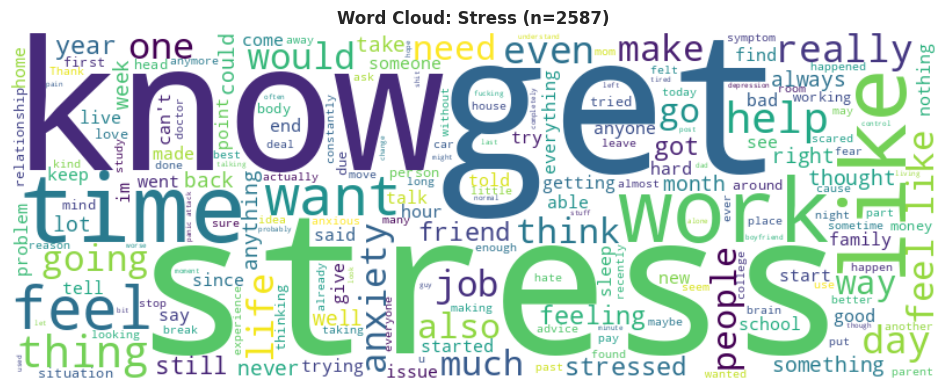

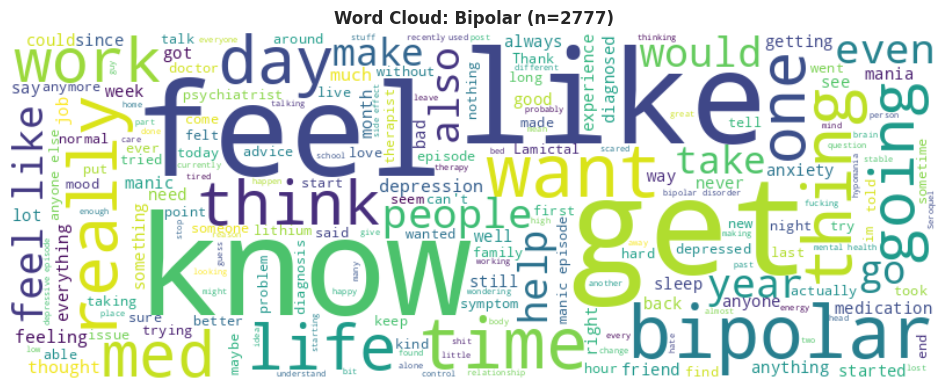

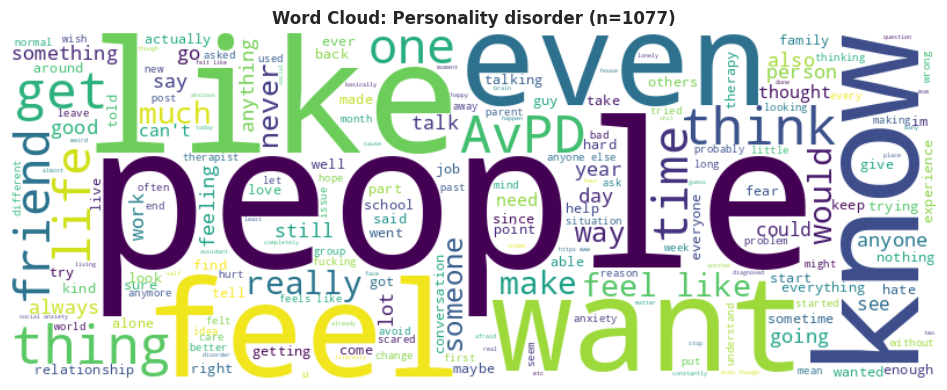


Generating overall word cloud...


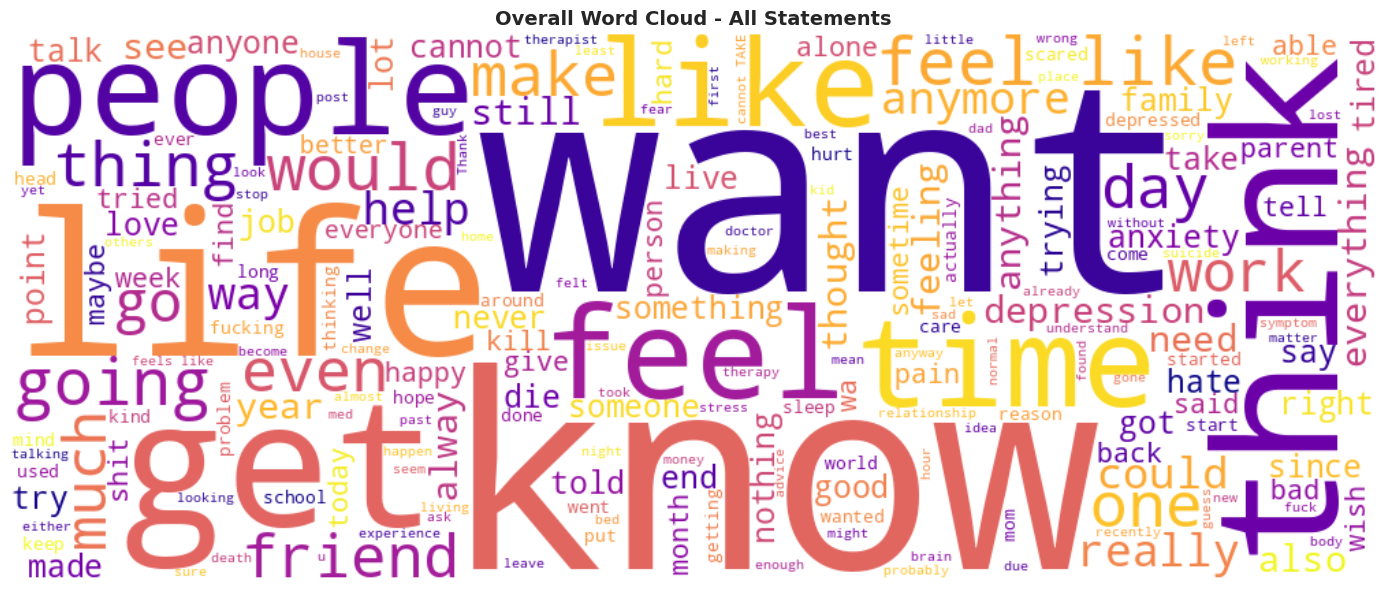


✓ Each mental health category now has its own disconnected word cloud.


In [ ]:
import subprocess
import sys

try:
    from wordcloud import WordCloud
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud", "-q"])
    from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

statuses = df['status'].unique()

print(f"\nGenerating word clouds for {len(statuses)} mental health categories...")

for status in statuses:
    status_text = ' '.join(df[df['status'] == status]['statement'].astype(str))
    
    wordcloud = WordCloud(
        width=800, height=300, 
        background_color='white',
        stopwords=stop_words,
        colormap='viridis'
    ).generate(status_text)

    plt.figure(figsize=(14, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud: {status} (n={len(df[df["status"] == status])})', 
              fontweight='bold', fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nGenerating overall word cloud...")

all_text = ' '.join(df['statement'].astype(str))
wordcloud_all = WordCloud(
    width=1000, height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='plasma'
).generate(all_text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Overall Word Cloud - All Statements',
          fontweight='bold', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n✓ Each mental health category now has its own disconnected word cloud.")

## 5. Text Metrics by Status

**What we're doing:** Comparing average text characteristics across different mental health status categories.

**Expected Output:** Bar charts showing how text length and word count vary by status.

**Observations:** Shows if certain mental health conditions have different text patterns.


TEXT METRICS BY MENTAL HEALTH STATUS:
                     text_length                          word_count  \
                            mean          std min    max        mean   
status                                                                 
Anxiety               764.681073   812.378061   7   8539  143.837022   
Bipolar               946.074901   952.510895  27  26163  176.200216   
Depression            844.031161   953.004199   3  19822  168.021488   
Normal                 90.244447   120.898909   2   1358   17.246283   
Personality disorder  956.731662  1149.828710  39  27588  179.346332   
Stress                613.545419   570.071569   6   8389  114.585234   
Suicidal              734.967330   982.210476   6  32759  146.440293   

                                            
                             std min   max  
status                                      
Anxiety               152.625874   1  1592  
Bipolar               176.488767   4  4804  
Depression     

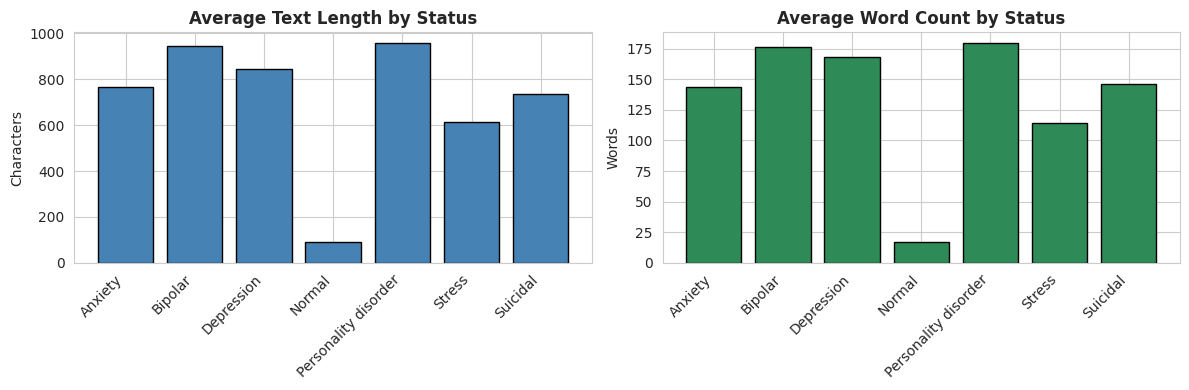


✓ Observation: Text characteristics vary by status category


In [ ]:
print("\nTEXT METRICS BY MENTAL HEALTH STATUS:")
status_text_stats = df.groupby('status')[['text_length', 'word_count']].agg(['mean', 'std', 'min', 'max'])
print(status_text_stats)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean_length = df.groupby('status')['text_length'].mean()
axes[0].bar(range(len(mean_length)), mean_length.values, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(mean_length)))
axes[0].set_xticklabels(mean_length.index, rotation=45, ha='right')
axes[0].set_title('Average Text Length by Status', fontweight='bold')
axes[0].set_ylabel('Characters')

mean_words = df.groupby('status')['word_count'].mean()
axes[1].bar(range(len(mean_words)), mean_words.values, color='seagreen', edgecolor='black')
axes[1].set_xticks(range(len(mean_words)))
axes[1].set_xticklabels(mean_words.index, rotation=45, ha='right')
axes[1].set_title('Average Word Count by Status', fontweight='bold')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

print("\n✓ Observation: Text characteristics vary by status category")

## 6. Data Quality Check

**Observations:** Identifies data cleaning requirements before model training.

**What we're doing:** Checking for data quality issues like duplicates, missing values, and encoding problems.

**Expected Output:** Summary statistics on data completeness and integrity.

In [ ]:
print("\nDATA QUALITY CHECK:")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Duplicate statements: {df['statement'].duplicated().sum()}")
print(f"Empty statements: {(df['text_length'] == 0).sum()}")
print(f"Very short statements (<10 chars): {(df['text_length'] < 10).sum()}")

encoding_issues = df['statement'].apply(lambda x: '™' in str(x) or '‚' in str(x) or 'â' in str(x))
print(f"Statements with encoding issues: {encoding_issues.sum()}")
print(f"\nData Quality Score: {(1 - (encoding_issues.sum() / len(df))) * 100:.1f}%")

if encoding_issues.sum() > 0:
    print(f"\n⚠ Note: {encoding_issues.sum()} statements need character encoding cleanup")


DATA QUALITY CHECK:
Duplicate rows: 1588
Duplicate statements: 1608
Empty statements: 0
Very short statements (<10 chars): 365
Statements with encoding issues: 782

Data Quality Score: 98.5%

⚠ Note: 782 statements need character encoding cleanup


## 7. EDA Summary & Key Insights

**Objective:** Summarize key findings from exploratory data analysis to guide model development and preprocessing decisions.

In [14]:
print("\n" + "="*70)
print("EDA SUMMARY & KEY INSIGHTS")
print("="*70)

status_dist = df['status'].value_counts()

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Total Records: {len(df)}")
print(f"   Mental Health Categories: {', '.join(df['status'].unique())}")
print(f"   No missing values (cleaned)")

print(f"\n🎯 CLASS DISTRIBUTION:")
for status, count in status_dist.items():
    pct = (count / len(df)) * 100
    print(f"   {status}: {count} ({pct:.1f}%)")
print(f"   Class Balance: {'✓ Balanced' if status_dist.std() < status_dist.mean() * 0.5 else '⚠ Imbalanced'}")

print(f"\n📝 TEXT CHARACTERISTICS:")
print(f"   Avg Length: {df['text_length'].mean():.0f} characters")
print(f"   Avg Words: {df['word_count'].mean():.1f} words")
print(f"   Range: {df['text_length'].min()}-{df['text_length'].max()} characters")
print(f"   Variability: Good (std dev = {df['text_length'].std():.0f})")

print(f"\n🔍 DATA QUALITY:")
print(f"   Duplicates: {df['statement'].duplicated().sum()}")
print(f"   Quality Score: {(1 - (encoding_issues.sum() / len(df))) * 100:.1f}%")

print(f"\n💡 KEY OBSERVATIONS:")
print(f"   1. Word clouds show common mental health themes")
print(f"   2. Different status categories have varying text patterns")
print(f"   3. Dataset is suitable for sentiment analysis and NLP modeling")
print(f"   4. Text preprocessing recommended (encoding fixes, normalization)")

print(f"\n✅ NEXT STEPS:")
print(f"   • Text preprocessing & cleaning")
print(f"   • Feature engineering (TF-IDF, embeddings)")
print(f"   • Model selection & training")
print(f"   • Handle class imbalance if needed")

print("\n" + "="*70)


EDA SUMMARY & KEY INSIGHTS

📊 DATASET OVERVIEW:
   Total Records: 52681
   Mental Health Categories: Anxiety, Normal, Depression, Suicidal, Stress, Bipolar, Personality disorder
   No missing values (cleaned)

🎯 CLASS DISTRIBUTION:
   Normal: 16343 (31.0%)
   Depression: 15404 (29.2%)
   Suicidal: 10652 (20.2%)
   Anxiety: 3841 (7.3%)
   Bipolar: 2777 (5.3%)
   Stress: 2587 (4.9%)
   Personality disorder: 1077 (2.0%)
   Class Balance: ⚠ Imbalanced

📝 TEXT CHARACTERISTICS:
   Avg Length: 579 characters
   Avg Words: 113.2 words
   Range: 2-32759 characters
   Variability: Good (std dev = 846)

🔍 DATA QUALITY:
   Duplicates: 1608
   Quality Score: 98.5%

💡 KEY OBSERVATIONS:
   1. Word clouds show common mental health themes
   2. Different status categories have varying text patterns
   3. Dataset is suitable for sentiment analysis and NLP modeling
   4. Text preprocessing recommended (encoding fixes, normalization)

✅ NEXT STEPS:
   • Text preprocessing & cleaning
   • Feature engineer

# Modelling Part 

In [15]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

original_statement   status  text_length  \
0                                         oh my gosh  Anxiety           10   
1  trouble sleeping, confused mind, restless hear...  Anxiety           64   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety           78   
3  I've shifted my focus to something else but I'...  Anxiety           61   
4  I'm restless and restless, it's been a month n...  Anxiety           72   

   word_count                                          statement  
0           3                                         oh my gosh  
1          10  trouble sleeping, confused mind, restless hear...  
2          14  all wrong, back off dear, forward doubt. stay ...  
3          11  i've shifted my focus to something else but i'...  
4          14  i'm restless and restless, it's been a month n...

In [ ]:
nltk.download('punkt_tab')
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

description = df[['num_of_characters', 'num_of_sentences']].describe()

print(description)

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.186367
std           846.269078         10.562006
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [ ]:
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

df['statement'] = df['statement'].apply(remove_patterns)
df.head()

original_statement   status  text_length  \
0                                         oh my gosh  Anxiety           10   
1  trouble sleeping, confused mind, restless hear...  Anxiety           64   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety           78   
3  I've shifted my focus to something else but I'...  Anxiety           61   
4  I'm restless and restless, it's been a month n...  Anxiety           72   

   word_count                                          statement  \
0           3                                         oh my gosh   
1          10  trouble sleeping confused mind restless heart ...   
2          14  all wrong back off dear forward doubt stay in ...   
3          11  ive shifted my focus to something else but im ...   
4          14  im restless and restless its been a month now ...   

   num_of_characters  num_of_sentences  
0                 10                 1  
1                 64                 2  
2                 78                 2  
3                 61                 1  
4                 72                 2

In [ ]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

original_statement   status  text_length  \
0                                         oh my gosh  Anxiety           10   
1  trouble sleeping, confused mind, restless hear...  Anxiety           64   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety           78   
3  I've shifted my focus to something else but I'...  Anxiety           61   
4  I'm restless and restless, it's been a month n...  Anxiety           72   

   word_count                                          statement  \
0           3                                         oh my gosh   
1          10  trouble sleeping confused mind restless heart ...   
2          14  all wrong back off dear forward doubt stay in ...   
3          11  ive shifted my focus to something else but im ...   
4          14  im restless and restless its been a month now ...   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                              tokens  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [all, wrong, back, off, dear, forward, doubt, ...  
3  [ive, shifted, my, focus, to, something, else,...  
4  [im, restless, and, restless, its, been, a, mo...

In [ ]:
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

original_statement   status  text_length  \
0                                         oh my gosh  Anxiety           10   
1  trouble sleeping, confused mind, restless hear...  Anxiety           64   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety           78   
3  I've shifted my focus to something else but I'...  Anxiety           61   
4  I'm restless and restless, it's been a month n...  Anxiety           72   

   word_count                                          statement  \
0           3                                         oh my gosh   
1          10  trouble sleeping confused mind restless heart ...   
2          14  all wrong back off dear forward doubt stay in ...   
3          11  ive shifted my focus to something else but im ...   
4          14  im restless and restless its been a month now ...   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                              tokens  \
0                                     [oh, my, gosh]   
1  [trouble, sleeping, confused, mind, restless, ...   
2  [all, wrong, back, off, dear, forward, doubt, ...   
3  [ive, shifted, my, focus, to, something, else,...   
4  [im, restless, and, restless, its, been, a, mo...   

                                      tokens_stemmed  
0                                         oh my gosh  
1  troubl sleep confus mind restless heart all ou...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shift my focu to someth els but im still w...  
4  im restless and restless it been a month now b...

In [21]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [22]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [25]:
X_train_combined.shape

(42144, 50002)

In [ ]:
from sklearn.utils import resample
from scipy.sparse import vstack

unique_classes, class_counts = np.unique(y_train, return_counts=True)
majority_class_count = class_counts.max()

X_train_combined_csr = X_train_combined.tocsr()

X_resampled_list = []
y_resampled_list = []

for class_label in unique_classes:
    X_class = X_train_combined_csr[y_train == class_label]
    y_class = y_train[y_train == class_label]

    if len(y_class) < majority_class_count:
        X_resampled_class, y_resampled_class = resample(X_class, y_class,
                                                        replace=True,
                                                        n_samples=majority_class_count,
                                                        random_state=101)
    else:
        X_resampled_class, y_resampled_class = X_class, y_class

    X_resampled_list.append(X_resampled_class)
    y_resampled_list.append(y_resampled_class)

X_train_resampled = vstack(X_resampled_list)
y_train_resampled = np.concatenate(y_resampled_list)

In [27]:
X_train_resampled.shape

(91742, 50002)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Multinomial Naive Bayes': MultinomialNB(alpha=0.1), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.640694694884692
                      precision    recall  f1-score   support

             Anxiety       0.65      0.60      0.62       768
             Bipolar       0.69      0.59      0.63       566
          Depression       0.66      0.47      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.88      0.35      0.50       202
              Stress       0.41      0.52      0.46       530
            Suicidal       0.60      0.54      0.57      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



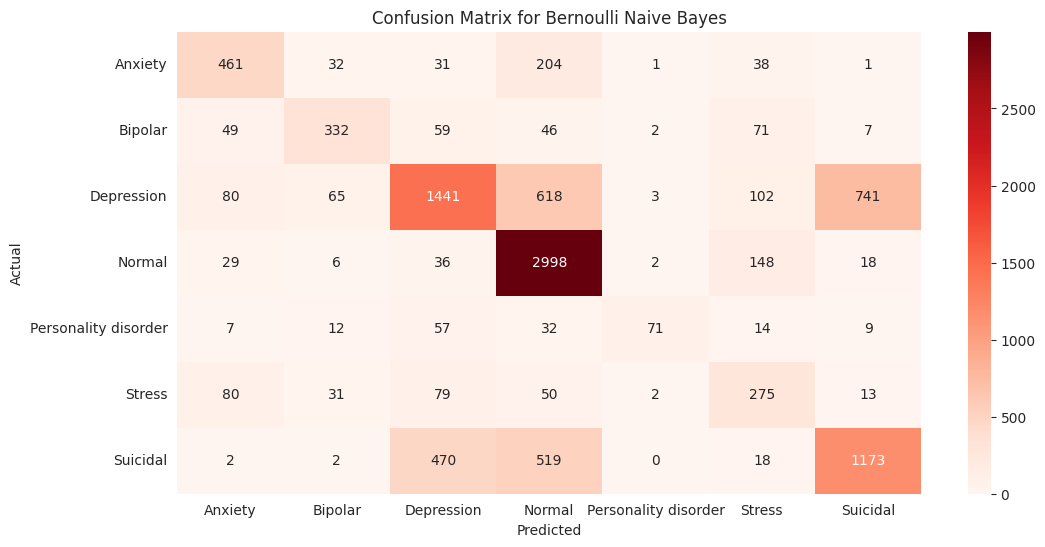



For Multinomial Naive Bayes
Accuracy: 0.7155736927019075
                      precision    recall  f1-score   support

             Anxiety       0.71      0.74      0.73       768
             Bipolar       0.61      0.81      0.69       566
          Depression       0.73      0.55      0.63      3050
              Normal       0.86      0.87      0.87      3237
Personality disorder       0.63      0.61      0.62       202
              Stress       0.50      0.61      0.55       530
            Suicidal       0.61      0.71      0.66      2184

            accuracy                           0.72     10537
           macro avg       0.67      0.70      0.68     10537
        weighted avg       0.72      0.72      0.71     10537



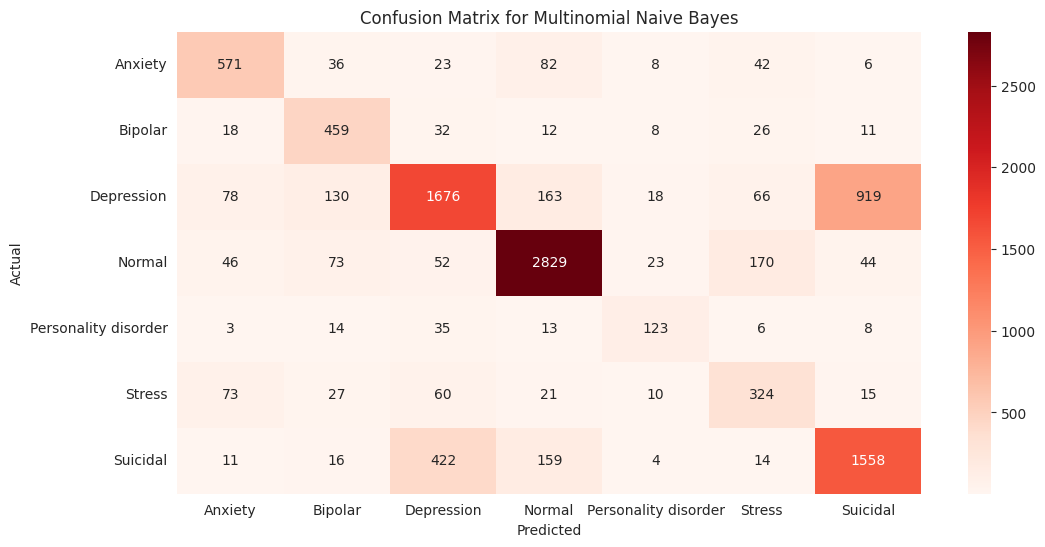



For Logistic Regression
Accuracy: 0.7615070703236215
                      precision    recall  f1-score   support

             Anxiety       0.77      0.82      0.79       768
             Bipolar       0.80      0.81      0.80       566
          Depression       0.73      0.64      0.68      3050
              Normal       0.89      0.93      0.91      3237
Personality disorder       0.67      0.66      0.67       202
              Stress       0.58      0.65      0.61       530
            Suicidal       0.65      0.69      0.67      2184

            accuracy                           0.76     10537
           macro avg       0.73      0.74      0.73     10537
        weighted avg       0.76      0.76      0.76     10537



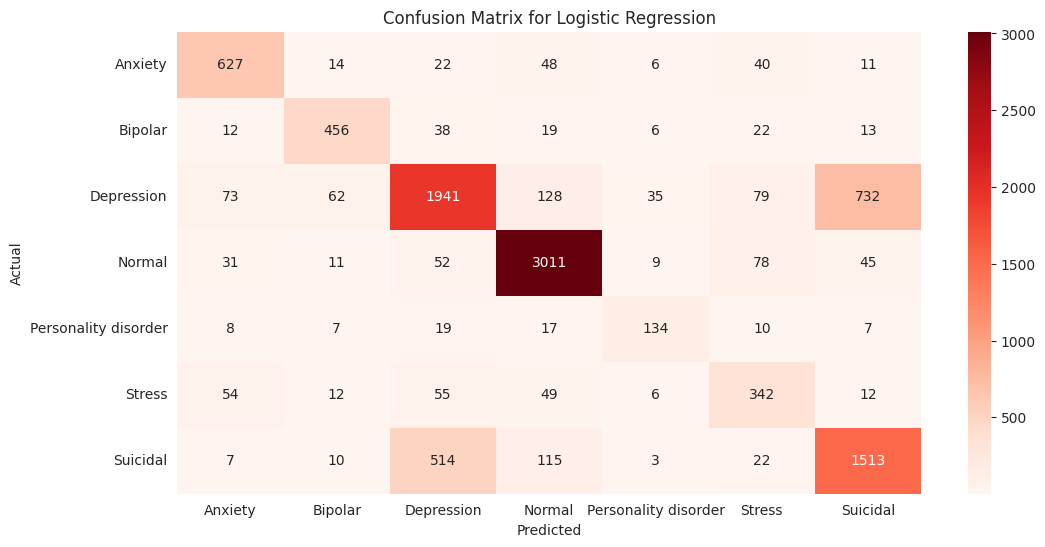



For XGB
Accuracy: 0.8021258422700959
                      precision    recall  f1-score   support

             Anxiety       0.82      0.85      0.84       768
             Bipolar       0.84      0.83      0.83       566
          Depression       0.79      0.69      0.73      3050
              Normal       0.92      0.94      0.93      3237
Personality disorder       0.78      0.65      0.71       202
              Stress       0.67      0.78      0.72       530
            Suicidal       0.68      0.75      0.71      2184

            accuracy                           0.80     10537
           macro avg       0.79      0.78      0.78     10537
        weighted avg       0.80      0.80      0.80     10537



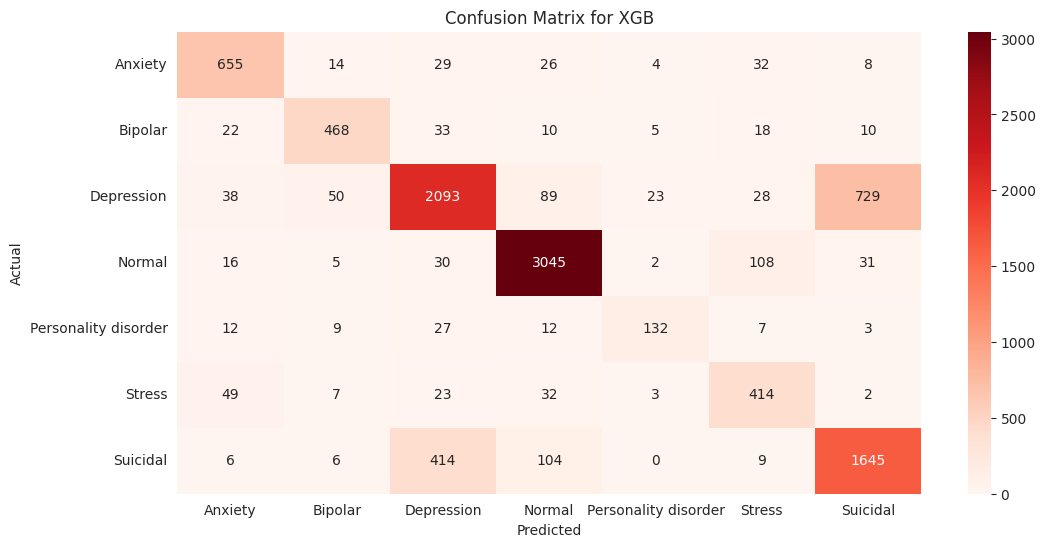

In [ ]:
accuracy_scores = []

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    accuracy_scores.append(accuracy)

In [ ]:
import joblib
import os

model_dir = '/kaggle/working/saved_models'
os.makedirs(model_dir, exist_ok=True)

for name, clf in classifiers.items():
    filename = name.replace(' ', '_').lower() + '.pkl'
    filepath = os.path.join(model_dir, filename)
    joblib.dump(clf, filepath)
    print(f"✓ Saved: {filename}")

joblib.dump(vectorizer, os.path.join(model_dir, 'tfidf_vectorizer.pkl'))
print("✓ Saved: tfidf_vectorizer.pkl")

joblib.dump(lbl_enc, os.path.join(model_dir, 'label_encoder.pkl'))
print("✓ Saved: label_encoder.pkl")

joblib.dump(stemmer, os.path.join(model_dir, 'porter_stemmer.pkl'))
print("✓ Saved: porter_stemmer.pkl")

print(f"\nAll models and preprocessing objects saved to '{model_dir}/' directory")
print(f"\nSaved files:")
for f in os.listdir(model_dir):
    file_size = os.path.getsize(os.path.join(model_dir, f)) / (1024 * 1024)
    print(f"   • {f} ({file_size:.2f} MB)")

print(f"\nTo download: Go to 'Output' tab on the right side of Kaggle notebook")
print(f"\nTo load models later:")
print("""
model = joblib.load('saved_models/xgb.pkl')
vectorizer = joblib.load('saved_models/tfidf_vectorizer.pkl')
label_encoder = joblib.load('saved_models/label_encoder.pkl')
stemmer = joblib.load('saved_models/porter_stemmer.pkl')

def predict_mental_health(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\\S+', '', text)
    text = re.sub(r'\\[.*?\\]\\(.*?\\)', '', text)
    text = re.sub(r'@\\w+', '', text)
    text = re.sub(r'[^\\w\\s]', '', text)
    
    tokens = word_tokenize(text)
    stemmed = ' '.join(stemmer.stem(token) for token in tokens)
    
    tfidf_features = vectorizer.transform([stemmed])
    num_features = [[len(text), len(nltk.sent_tokenize(text))]]
    combined = hstack([tfidf_features, num_features])
    
    prediction = model.predict(combined)
    return label_encoder.inverse_transform(prediction)[0]
""")

✓ Saved: bernoulli_naive_bayes.pkl
✓ Saved: multinomial_naive_bayes.pkl
✓ Saved: logistic_regression.pkl
✓ Saved: xgb.pkl
✓ Saved: tfidf_vectorizer.pkl
✓ Saved: label_encoder.pkl
✓ Saved: porter_stemmer.pkl

✅ All models and preprocessing objects saved to '/kaggle/working/saved_models/' directory

📁 Saved files:
   • bernoulli_naive_bayes.pkl (5.34 MB)
   • tfidf_vectorizer.pkl (11.38 MB)
   • xgb.pkl (7.55 MB)
   • multinomial_naive_bayes.pkl (5.34 MB)
   • logistic_regression.pkl (2.67 MB)
   • porter_stemmer.pkl (0.00 MB)
   • label_encoder.pkl (0.00 MB)

💡 To download: Go to 'Output' tab on the right side of Kaggle notebook

📝 To load models later:

# Load the model and preprocessing objects
model = joblib.load('saved_models/xgb.pkl')
vectorizer = joblib.load('saved_models/tfidf_vectorizer.pkl')
label_encoder = joblib.load('saved_models/label_encoder.pkl')
stemmer = joblib.load('saved_models/porter_stemmer.pkl')

# Example prediction function
def predict_mental_health(text):
    # 